In [154]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from util.util_cnn import *
from util.util_lrp import *
from util.naming import *
from util.util_data_summary import pretty_num

from util.util_gamma_rule import calc_vals_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# load data and pretrained models
data, target = first_mnist_batch()

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

Attempt loading: mnist first_batch_1000


In [139]:
A, A_pos, A_neg, layers = layerwise_forward_pass(model_d3, data, pos_neg=True)
shapes = [a.shape for a in A]
for i, s in enumerate(shapes):
    mean = torch.mean(A[i])
    quantiles = torch.quantile(A[i], torch.tensor([0,5,50,95,100])/100)
    qs = f'\tmean: {mean:2.3f} \t qs:'
    for q in quantiles: qs += f'\t{q:2.3f}'
    print(i, tuple(s), qs, end=' ')
    if i < len(layers): print('->', layers[i] or 1)

0 (100, 1, 28, 28) 	mean: 0.136 	 qs:	0.000	0.000	0.000	0.992	1.000 -> Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 (100, 8, 28, 28) 	mean: 0.206 	 qs:	-1.320	-0.313	0.162	0.821	2.173 -> ReLU()
2 (100, 8, 28, 28) 	mean: 0.245 	 qs:	0.000	0.000	0.162	0.821	2.173 -> Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 (100, 8, 28, 28) 	mean: 0.182 	 qs:	-1.666	-0.521	-0.000	1.162	6.522 -> ReLU()
4 (100, 8, 28, 28) 	mean: 0.287 	 qs:	0.000	0.000	0.000	1.162	6.522 -> Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
5 (100, 8, 24, 24) 	mean: 0.388 	 qs:	-5.179	-1.619	-0.167	5.279	11.667 -> ReLU()
6 (100, 8, 24, 24) 	mean: 0.775 	 qs:	0.000	0.000	0.000	5.279	11.667 -> MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
7 (100, 8, 12, 12) 	mean: 1.088 	 qs:	0.000	0.000	0.000	6.520	11.667 -> Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
8 (100, 16, 8, 8) 	mean: -0.672 	 qs:	-31.368	-10.492	-0.956	9.566	26.949 -> ReLU()
9 (100, 16, 8, 8

In [142]:
for i, a in enumerate(yneg):
    if a is not None:
        print(i, a.shape, a.min().item(), a.max().item())
    else: print(i, a)

0 torch.Size([139]) 0.007843137718737125 1.0
1 torch.Size([2255]) -1.8125604391098022 2.9802322387695312e-08
2 torch.Size([139]) 0.007843137718737125 1.0
3 torch.Size([6272]) -2.059638738632202 -0.05487585812807083
4 torch.Size([139]) 0.007843137718737125 1.0
5 torch.Size([4608]) -7.171913146972656 -0.5637726783752441
6 torch.Size([139]) 0.007843137718737125 1.0
7 torch.Size([139]) 0.007843137718737125 1.0
8 torch.Size([1024]) -28.366531372070312 -0.5523945093154907
9 torch.Size([139]) 0.007843137718737125 1.0
10 torch.Size([1024]) -21.879302978515625 -0.4187057912349701
11 torch.Size([139]) 0.007843137718737125 1.0
12 torch.Size([1024]) -25.158082962036133 -1.0709240436553955
13 torch.Size([139]) 0.007843137718737125 1.0
14 torch.Size([139]) 0.007843137718737125 1.0
15 torch.Size([139]) 0.007843137718737125 1.0
16 torch.Size([10]) -14.000922203063965 -4.587940216064453


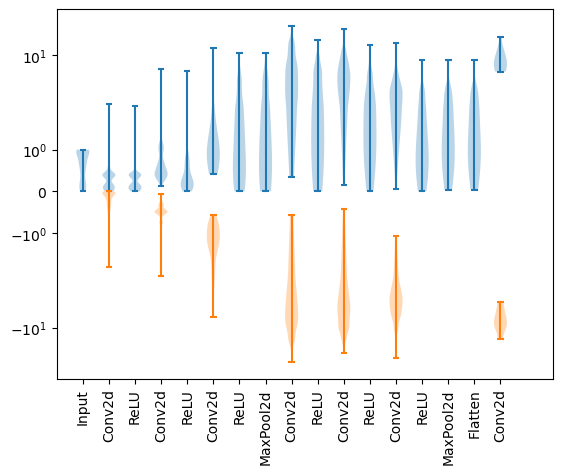

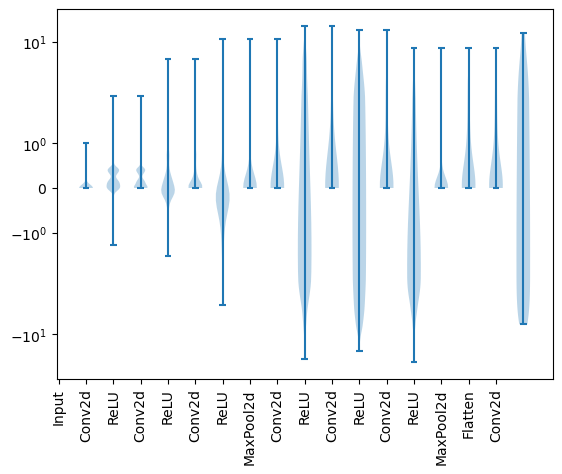

In [146]:
yscale = 'symlog'

ia, ib = 0, 1

def filter(x):
    x = x.flatten()
    x = x[x != 0]
    return x

plus = 0
xpos = [i + plus for i, a in enumerate(A_pos) if a is not None]
xneg = [i + plus for i, a in enumerate(A_neg) if a is not None]
ypos = [filter(a[ia:ib]) for a in A_pos if a is not None]
yneg = [filter(a[ia:ib]) for a in A_neg if a is not None]
y    = [a[ia:ib].flatten() for a in A if a is not None]

ticks = ['Input'] + [str(l).split('(')[0] for l in layers]

plt.violinplot(ypos, xpos)
plt.violinplot(yneg, xneg)
plt.yscale(yscale)
ax = plt.gca()
ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks, rotation=90)
ax.set_xlim(-1, 18)

plt.show()

plt.violinplot(y)
plt.yscale(yscale)
ax = plt.gca()
ax.set_xticks(np.arange(len(ticks)))
ax.set_xticklabels(ticks, rotation=90);

In [153]:
for i, y in enumerate(ypos):
    qs = torch.quantile(y, torch.tensor([.01, .05, .1, .25, .5, .75, 1])) # .tolist()
    print(i, ticks[i], '\t', qs)

0 Input 	 tensor([0.0118, 0.0353, 0.0510, 0.2765, 0.7020, 0.9922, 1.0000])
1 Conv2d 	 tensor([6.2198e-05, 6.2198e-05, 1.6401e-03, 1.1337e-01, 3.3347e-01, 4.1433e-01,
        2.2093e+00])
2 ReLU 	 tensor([6.2173e-05, 6.2193e-05, 6.2220e-05, 8.3976e-02, 1.7171e-01, 4.1329e-01,
        2.1231e+00])
3 Conv2d 	 tensor([0.2372, 0.2864, 0.3582, 0.3951, 0.5637, 0.9400, 6.5600])
4 ReLU 	 tensor([4.6445e-03, 3.4871e-02, 8.6305e-02, 1.1551e-01, 2.9528e-01, 7.1455e-01,
        6.1578e+00])
5 Conv2d 	 tensor([ 0.4453,  0.4667,  0.5360,  0.7112,  1.0735,  1.9323, 12.5675])
6 ReLU 	 tensor([ 0.0141,  0.0630,  0.1290,  0.5813,  1.7485,  3.9992, 10.6765])
7 MaxPool2d 	 tensor([ 0.0142,  0.0511,  0.0698,  0.6139,  2.0843,  4.4873, 10.6765])
8 Conv2d 	 tensor([ 0.8678,  1.5587,  2.1479,  3.9374,  7.1526, 11.8466, 24.3290])
9 ReLU 	 tensor([ 0.0484,  0.1898,  0.4269,  1.3685,  3.6497,  6.4921, 15.6791])
10 Conv2d 	 tensor([ 1.0604,  1.7595,  2.4083,  3.8878,  6.0245,  8.6683, 22.3256])
11 ReLU 	 tensor([ 

## Varying cutoffs

In [261]:
l_out = 12

mat_funcs = [partial(LRP_global_mat, model=model_d3, l_inp=0, l_out=l_out, l_ub=1000, delete_unactivated_subnetwork=False, normalized=True)]
mats = calc_mats_batch_functional(mat_funcs, gammas40, data[:1], tqdm_for='gamma')
ticks[l_out], mats, A[l_out][0].flatten().shape









































































































































































































100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


('Conv2d',
 array([[[<784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<class 'numpy.float32'>'
          	with 520448 stored elements in COOrdinate format>      ,
          <784x1024 sparse array of type '<c

In [282]:
from copy import deepcopy

# mats_save = deepcopy(mats)
# mats = deepcopy(mats_save)
mats.shape

NameError: name 'mats_save' is not defined

In [294]:
a = A[l_out]
mats_different_cutoffs = \
[
    batch_transform_xai_mat(mats, a, first_p_pos=percentile)[0] 
    for percentile in [50, 75, 95, 99, 100]
] + [mats[0]]

mats_different_cutoffs = np.array(mats_different_cutoffs)

In [295]:
svals = calc_vals_batch(mats_different_cutoffs, tqdm_for='gamma')

40it [00:01, 25.31it/s]
40it [00:04,  8.77it/s]
40it [00:08,  4.61it/s]
40it [00:08,  4.58it/s]
40it [00:08,  4.97it/s]
40it [01:45,  2.64s/it]


Warn: Invalid xlim: p100. Setting xlim to None.


(<Figure size 3000x300 with 6 Axes>,
 array([<AxesSubplot:xlabel='$\\gamma$', ylabel='Singular values'>,
        <AxesSubplot:xlabel='$\\gamma$'>, <AxesSubplot:xlabel='$\\gamma$'>,
        <AxesSubplot:xlabel='$\\gamma$'>, <AxesSubplot:xlabel='$\\gamma$'>,
        <AxesSubplot:xlabel='$\\gamma$'>], dtype=object))

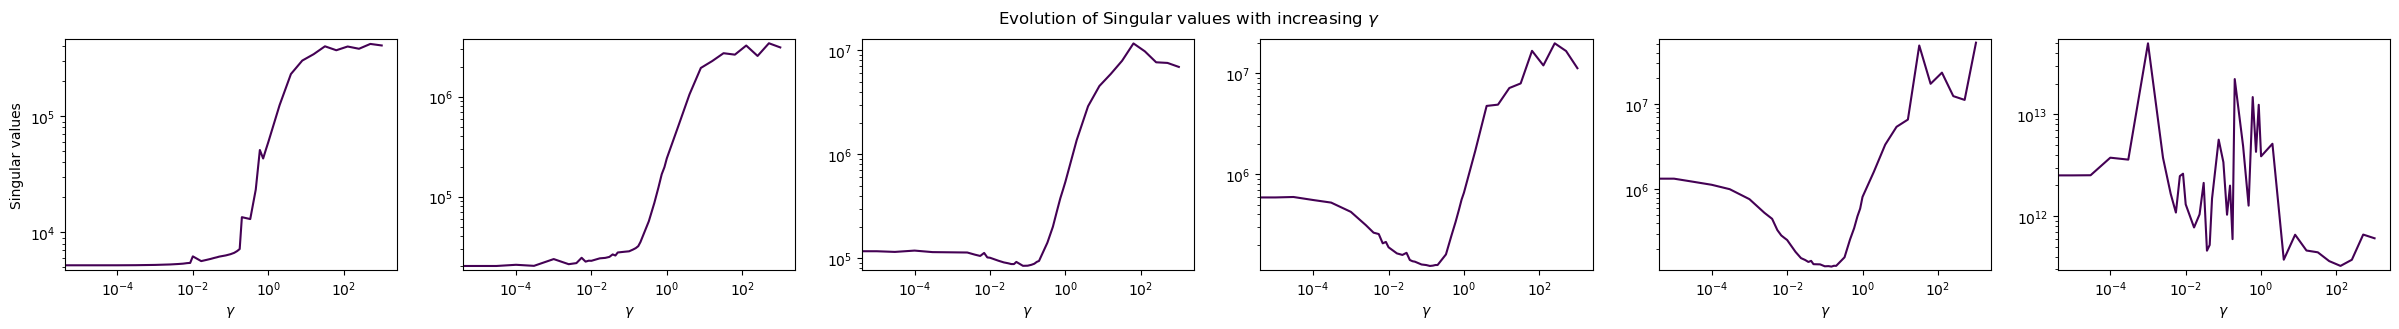

In [300]:
from util.util_data_summary import condition_number, plot_vals_lineplot

plot_vals_lineplot(condition_number(svals, percentile=(0, .8)), ylim='p100', xlim='p100', yscale='log', xscale='log')

In [311]:
heatmaps_all_features_summed = np.array([mat.sum(axis=1) for mat in mats_different_cutoffs.flatten()]).reshape((*mats_different_cutoffs.shape, 28, 28))
heatmaps_all_features_summed.shape

(6, 1, 40, 28, 28)

0
[3.7446153 2.1571102 1.9530565 1.194531  1.1215254 1.1791171]


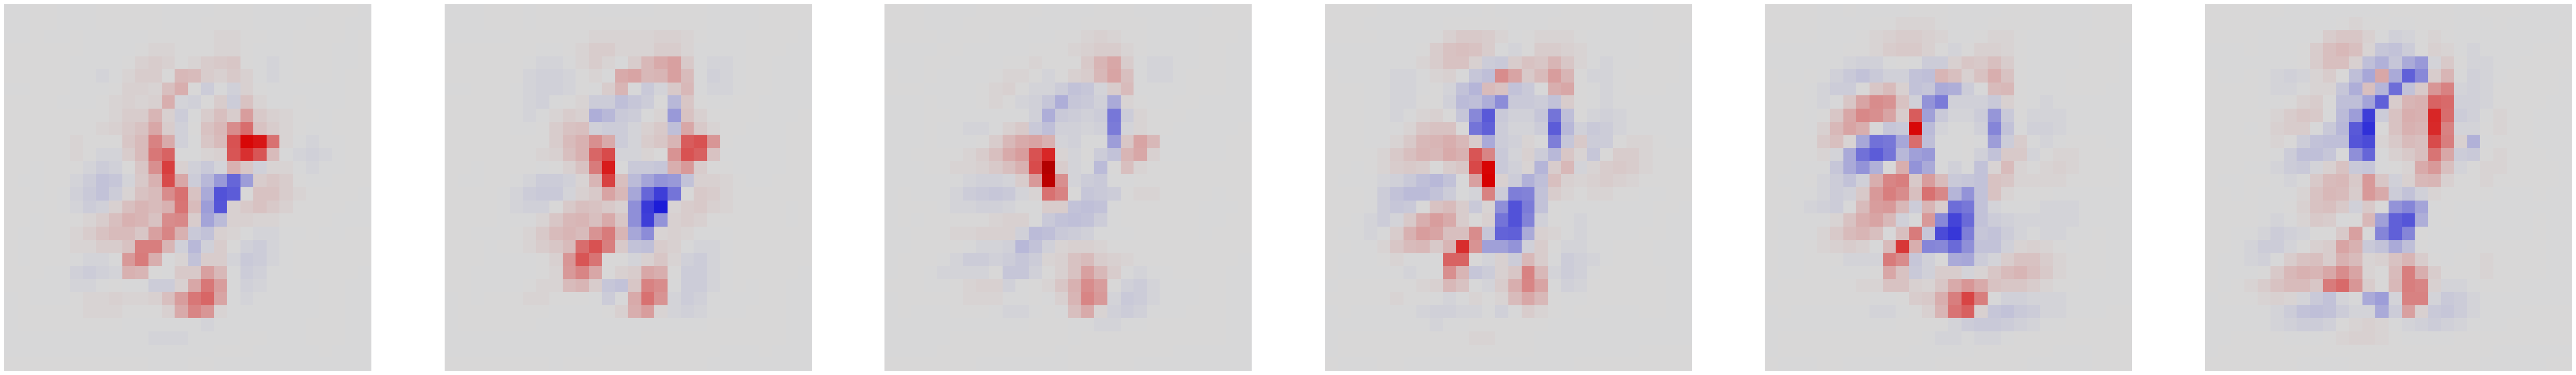

0.017
[5.087114  2.9053502 3.2386615 2.0612254 1.9618589 3.4515479]


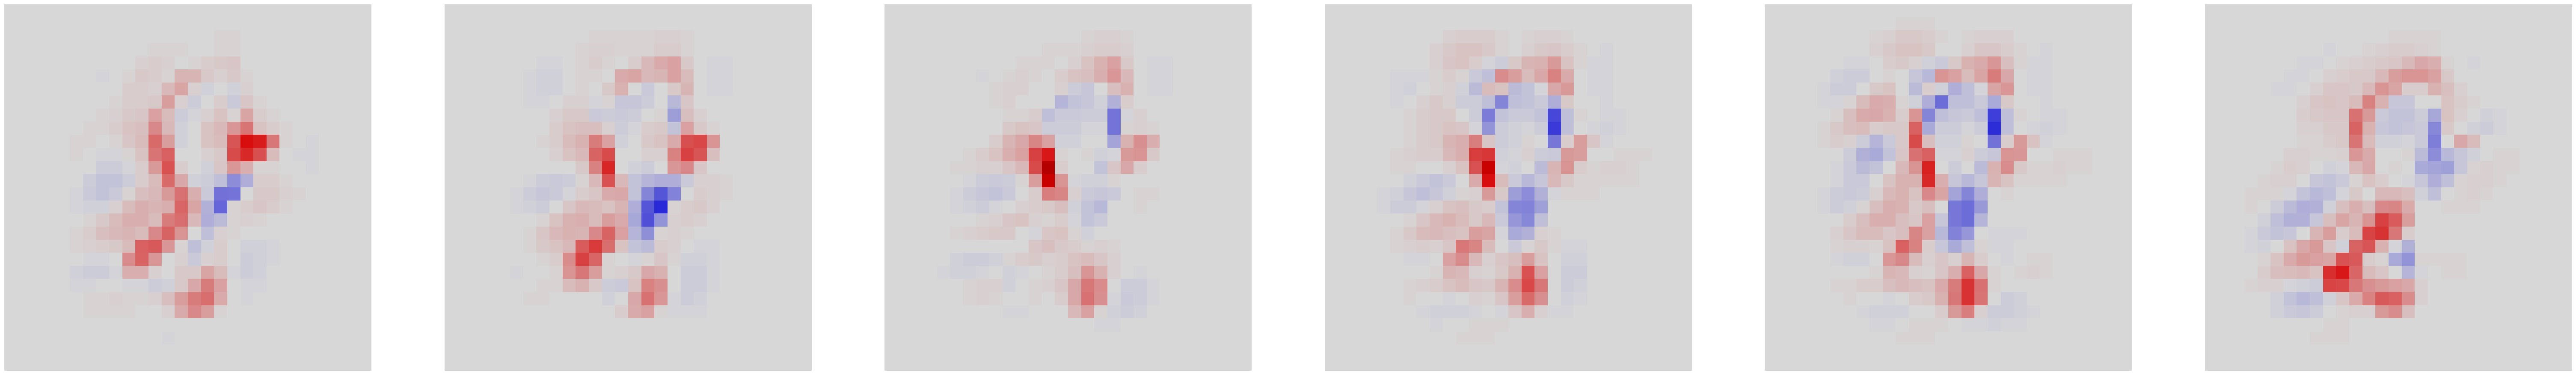

0.175
[35.618187 23.598484 23.910528 21.53085  21.403187  8.548089]


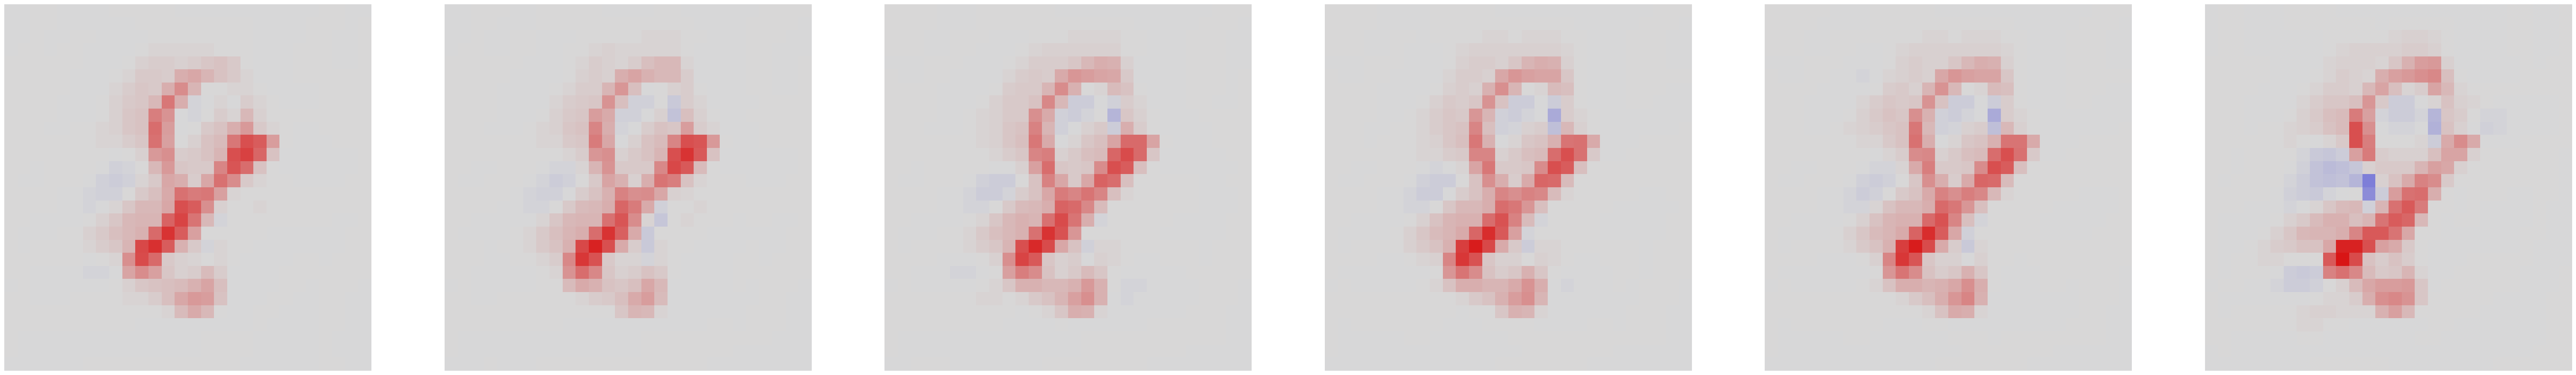

0.467
[198.85158  181.6269   172.1705   169.23807  172.97243    8.380423]


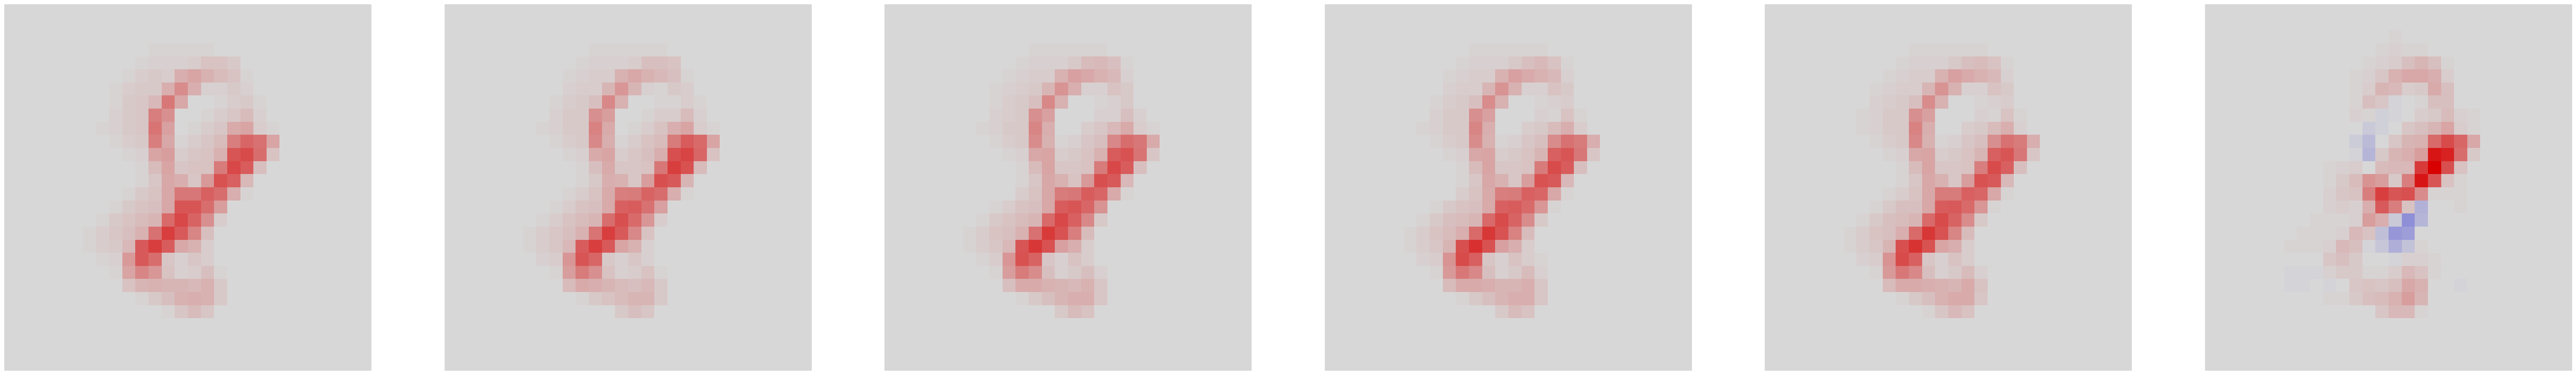

4
[ 923667.2   900135.06 1084086.2  1132307.6  1112888.4   328432.03]


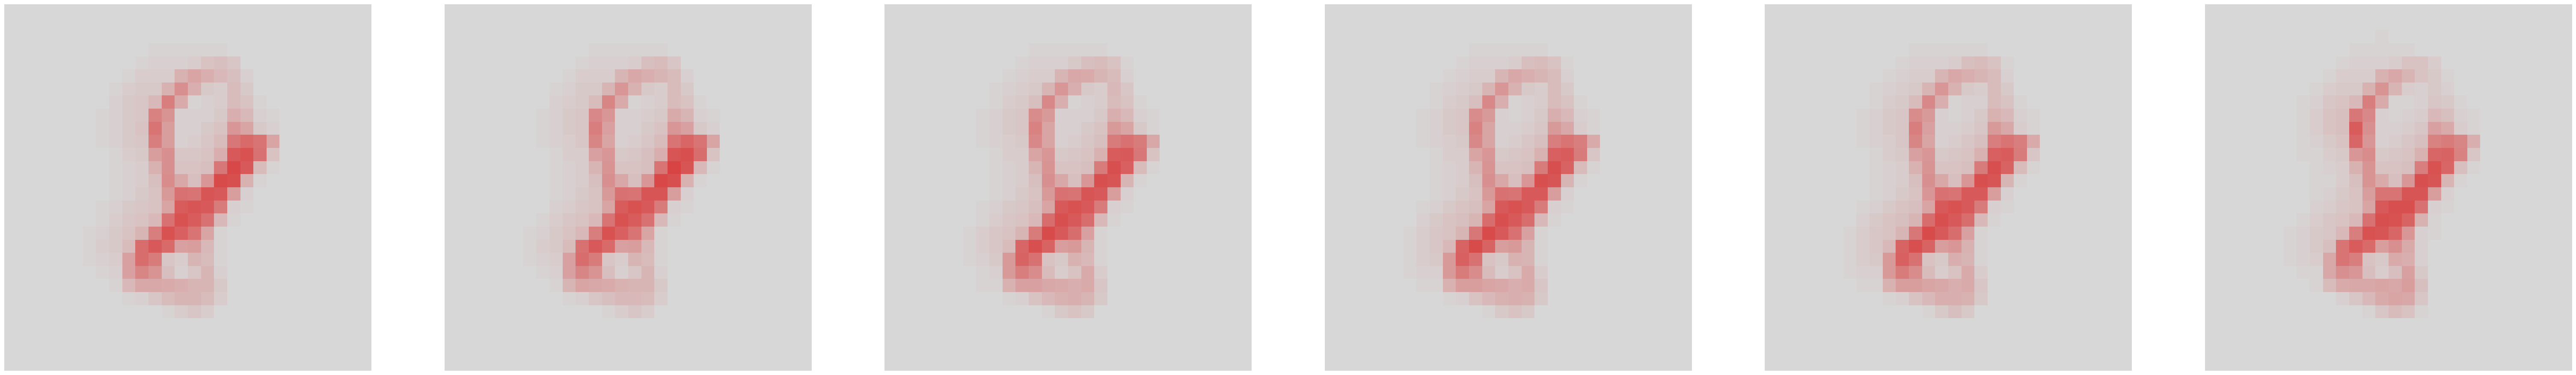

In [329]:
from util.util_tutorial import heatmap_batch
gamma_selection = [0, 12, 22, 25, 31]

for i in gamma_selection: 
    hs = heatmaps_all_features_summed[:,0,i]
    print(pretty_num(gammas40[i]))
    ps = hs.clip(0)
    ns = hs.clip(None, 0)
    ratio = - ps.sum(axis=(1,2)) / ns.sum(axis=(1,2))
    print(ratio)
    heatmap_batch(hs, 10, 10, False)

# highly positively activated neurons seem to have a lower ratio of negative evidence
# 

lines minima dist


(<Figure size 500x600 with 1 Axes>, [<AxesSubplot:ylabel='$\\kappa_q$'>])

<Figure size 640x480 with 0 Axes>

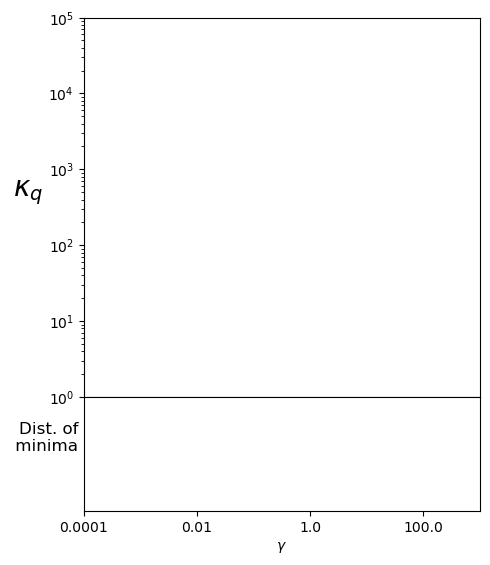

In [252]:
from util.util_data_summary import plot_condition_number


plot_condition_number(svals)

In [216]:
a = A[l_out][0].flatten()
summed_filtered = torch.tensor(summed)[a<0]
summed_filtered.shape

torch.Size([847])

In [217]:
torch.quantile(summed_filtered, torch.tensor([.01, .05, .1, .25, .5, .75, .95, .99, 1]))

tensor([-0.3085,  0.7377,  0.8363,  0.8976,  0.9468,  0.9902,  1.1157,  1.4755,
        10.6345])

In [218]:
torch.quantile(a[a<0], torch.tensor([.01, .05, .1, .25, .5, .75, .95, .99, 1]))

tensor([-1.5642e+01, -9.6245e+00, -7.7572e+00, -4.9744e+00, -2.8500e+00,
        -1.4945e+00, -4.1825e-01, -7.4047e-02, -2.1435e-03])